In [43]:
import pandas as pd
import seaborn as sns
import json
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, apriori, association_rules
from functools import reduce
from collections import OrderedDict

pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_columns", None)

# Importing data

In [44]:
canada_hospital_1 = pd.read_excel("./data/uncover/Canada_Hosp_COVID19_Inpatient_DatasetDefinitions/Canada_Hosp1_COVID_InpatientData.xlsx")
canada_hospital_2 = pd.read_excel("./data/uncover/Canada_Hosp_COVID19_Inpatient_DatasetDefinitions/Canada_Hosp2_COVID_InpatientData.xlsx")
canada_hospital = pd.concat([canada_hospital_1, canada_hospital_2])

In [45]:
canada_hospital.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 200
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                709 non-null    float64
 1   reason_for_admission              707 non-null    object 
 2   age                               709 non-null    float64
 3   sex                               706 non-null    object 
 4   ethnicity                         709 non-null    object 
 5   ethnicity_other                   58 non-null     object 
 6   height                            297 non-null    float64
 7   weight                            389 non-null    float64
 8   comorbidities                     709 non-null    object 
 9   comorbidities_other               521 non-null    object 
 10  received_covid_vaccine            188 non-null    object 
 11  covid_vaccine                     1 non-null      object 
 12  medicati

# Preprocessing

## Fix missing values

In [46]:
canada_hospital[canada_hospital["sex"].isnull()]

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
36,37.0,COVID-19,77.0,NaN,"""[]""",NaN,NaN,NaN,"""[]""","Obstructive sleep apnea, hiatus hernia, GERD, dyslipidemia, depression/anxiety",NaN,NaN,"""[{\""medications\"":\""atorvastati\"",\""dosage\"":\""20\"",\""frequency\"":\""Please Select an option\""}]""",Ex-smoker,1986.0,No,WARD,92.0,42.0,83.0,22.0,95.0,37.4,NaN,NaN,NaN,NaN,4.7,4.74,145.0,0.421,88.7,30.6,345.0,13.5,181.0,NaN,11.7,18.0,NaN,75.0,141.0,3.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,1.07,NaN,NaN,NaN,NaN
55,56.0,COVID-19 positive,57.0,NaN,"""[]""",NaN,NaN,NaN,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""GABAPENTIN\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""},{\""medications\"":\""Codeine\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""},{\""medications\"":\""VALACYCLOVIR\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""}]""",Ex-smoker,NaN,No,ICU,112.0,75.0,104.0,44.0,92.0,38.0,NaN,NaN,NaN,Yes,7.6,4.20,132.0,0.388,92.4,31.5,341.0,15.0,252.0,NaN,NaN,26.0,NaN,97.0,132.0,4.4,7.0,2.3,NaN,NaN,7.33,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108,109.0,"Presented to ED with neutropenic fever, COVID-19 Admission",71.0,NaN,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\"",\""Cancer [active only]\"",\""Diabetes\"",\""Other\""]""",NaN,No,NaN,"""[{\""medications\"":\""RAMIPRIL\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""},{\""medications\"":\""ROSUVASTATIN\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""},{\""medications\"":\""amiodipine\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""},{\""medications\"":\""apixaban\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",Non-smoker,NaN,No,WARD,117.0,72.0,113.0,24.0,98.0,38.4,NaN,NaN,NaN,No,0.2,2.86,82.0,0.243,85.0,28.7,338.0,13.6,52.0,NaN,NaN,108.0,NaN,NaN,137.0,3.8,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
canada_hospital["sex"] = canada_hospital["sex"].fillna("Other Gender")

In [48]:
canada_hospital.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 709 entries, 0 to 200
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                709 non-null    float64
 1   reason_for_admission              707 non-null    object 
 2   age                               709 non-null    float64
 3   sex                               709 non-null    object 
 4   ethnicity                         709 non-null    object 
 5   ethnicity_other                   58 non-null     object 
 6   height                            297 non-null    float64
 7   weight                            389 non-null    float64
 8   comorbidities                     709 non-null    object 
 9   comorbidities_other               521 non-null    object 
 10  received_covid_vaccine            188 non-null    object 
 11  covid_vaccine                     1 non-null      object 
 12  medicati

## Filter only patients infected with Covid-19

In [49]:
canada_hospital = canada_hospital[canada_hospital["reason_for_admission"].notna()]

In [50]:
canada_hospital.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707 entries, 0 to 200
Data columns (total 55 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                707 non-null    float64
 1   reason_for_admission              707 non-null    object 
 2   age                               707 non-null    float64
 3   sex                               707 non-null    object 
 4   ethnicity                         707 non-null    object 
 5   ethnicity_other                   58 non-null     object 
 6   height                            297 non-null    float64
 7   weight                            389 non-null    float64
 8   comorbidities                     707 non-null    object 
 9   comorbidities_other               519 non-null    object 
 10  received_covid_vaccine            187 non-null    object 
 11  covid_vaccine                     1 non-null      object 
 12  medicati

In [51]:
canada_hospital.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
0,1.0,Fever [R50.9],74.0,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""","GERD (gastroesophageal reflux disease), Dementia Depression, Barrett esophagus, Pneumonia, Schizophrenia, Hiatus Hernia, Reflux esophagitis",NaN,NaN,"""[{\""medications\"":\""TYLENOL EXTRA STRENGTH\"",\""dosage\"":\""325\"",\""frequency\"":\""OD\""},{\""medications\"":\""ROSUVASTATIN\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""NORVASC\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""DULCOLAX\"",\""dosage\"":\""10\"",\""frequency\"":\""OD\""},{\""medications\"":\""WELLBUTRIN XL\"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1,000 UNITS\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLOZAPINE\"",\""dosage\"":\""250\"",\""frequency\"":\""OD\""},{\""medications\"":\""FERROUS FUMARATE SCT TAB \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""LACTULOSE\"",\""dosage\"":\""30 grams\"",\""frequency\"":\""BID\""},{\""medications\"":\""KEPPRA\"",\""dosage\"":\""500\"",\""frequency\"":\""BID\""},{\""medications\"":\""GLUCOPHAGE\"",\""dosage\"":\""250\"",\""frequency\"":\""BID\""},{\""medications\"":\""PANTOLOC\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLEARLAX\"",\""dosage\"":\""17 grams\"",\""frequency\"":\""BID\""},{\""medications\"":\""ALTACE CAP \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLOZAPINE\"",\""dosage\"":\""150\"",\""frequency\"":\""OD\""},{\""medications\"":\""CLOZAPINE\"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENEKOT\"",\""dosage\"":\""8.6/ 2 Tab\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENEKOT\"",\""dosage\"":\""8.6/3 Tab\"",\""frequency\"":\""OD\""}]""",NaN,NaN,No,WARD,99.0,62.0,85.0,20.0,93.0,37.5,6.0,4.0,4.0,No,11.0,5.63,132.0,0.406,72.1,23.4,325.0,18.5,128.0,44.0,14.1,53.0,49.0,165.0,135.0,3.9,10.0,2.3,NaN,NaN,NaN,NaN,NaN,1.1,NaN,NaN,223.0,NaN
1,2.0,Pneumonia [J18.9],61.0,Female,"""[]""",NaN,154.9,73.6,"""[\""Hypertension\"",\""Other\""]""","Closed fracture of fifth metatarsal bone, Diverticulosis, Irritable bowel syndrome, Vertigo",NaN,NaN,"""[{\""medications\"":\""CANDESARTAN\"",\""dosage\"":\""8\"",\""frequency\"":\""OD\""}]""",NaN,NaN,No,WARD,122.0,77.0,93.0,36.0,88.0,38.0,6.0,5.0,4.0,No,5.0,4.49,121.0,0.353,78.6,26.9,343.0,14.2,236.0,28.0,12.9,68.0,68.0,49.0,137.0,3.8,12.0,1.5,NaN,NaN,NaN,NaN,NaN,1.0,NaN,2354.0,95.6,NaN
2,3.0,Pneumonia [J18.9],58.0,Female,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""OD\""}]""",NaN,NaN,No,WARD,109.0,72.0,73.0,24.0,91.0,38.3,6.0,5.0,3.0,No,6.2,4.31,119.0,0.362,84.0,27.6,329.0,12.5,249.0,NaN,NaN,52.0,76.0,71.0,135.0,3.7,7.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4.0,Suspected COVID-19 virus infection [U07.2],94.0,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""f

In [52]:
canada_hospital_covid19 = canada_hospital[canada_hospital["reason_for_admission"].str.contains("covid", case=False)]

In [53]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],94.0,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],50.0,Male,"""[]""",NaN,188.0,91.1,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],57.0,Male,"""[]""",NaN,178.0,58.0,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],76.0,Female,"""[]""",NaN,162.0,72.6,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""",Hypercholesteremia,NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],86.0,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Transform quantitative to categorical

### Age

In [54]:
age_ranges = [0, 17, 44, 64, 100]
age_labels = ["<18 years", "18-45 years", "45-65 years", ">65 years"]
canada_hospital_covid19["age"] = pd.cut(canada_hospital_covid19["age"], bins=age_ranges, labels=age_labels).astype(str)

/tmp/ipykernel_59097/2858373239.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_hospital_covid19["age"] = pd.cut(canada_hospital_covid19["age"], bins=age_ranges, labels=age_labels).astype(str)


In [55]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],>65 years,Male,"""[]""",NaN,182.8,66.2,"""[\""Hypertension\"",\""Other\""]""","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,188.0,91.1,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,178.0,58.0,"""[]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],>65 years,Female,"""[]""",NaN,162.0,72.6,"""[\""Hypertension\"",\""Diabetes\"",\""Other\""]""",Hypercholesteremia,NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],>65 years,Male,"""[]""",NaN,NaN,NaN,"""[\""Hypertension\""]""",NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:>

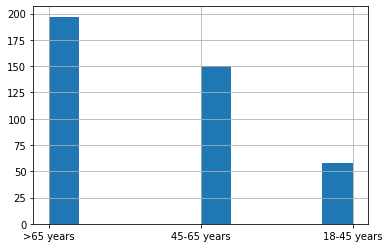

In [56]:
# ages = sns.load_dataset(canada_hospital_covid19["age"])
canada_hospital_covid19["age"].hist()

## Transform raw `comorbidities` data

### Major comorbidities

In [57]:
canada_hospital_covid19["comorbidities"] = canada_hospital_covid19["comorbidities"].map(lambda cell: list(map(lambda x: x.lower(), json.loads(json.loads(cell)))))

/tmp/ipykernel_59097/3735221934.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_hospital_covid19["comorbidities"] = canada_hospital_covid19["comorbidities"].map(lambda cell: list(map(lambda x: x.lower(), json.loads(json.loads(cell)))))


In [58]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],>65 years,Male,"""[]""",NaN,182.8,66.2,"[hypertension, other]","Parkinson's Disease, Back pain, Benign Prostatic Hyperplasia, Cholecystitis, Chronic Kidney Disease, Fall, Gastroesophageal reflux disease, Gout, History of total hip replacement left hip, Osteoporosis,",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,188.0,91.1,[],NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,178.0,58.0,[],NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],>65 years,Female,"""[]""",NaN,162.0,72.6,"[hypertension, diabetes, other]",Hypercholesteremia,NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],>65 years,Male,"""[]""",NaN,NaN,NaN,[hypertension],NaN,NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Other comorbidities

In [59]:
def transform_other_comorbidities(cell):
  if isinstance(cell, str):
    other_comorbidities = cell.rstrip(",").rstrip(".").replace("\t", "").lower().split(", ")

    return list(filter(lambda other_comorbidity: other_comorbidity != "", map(lambda other_comorbidity: other_comorbidity.strip().strip("\""), other_comorbidities)))
  else:
    return []

canada_hospital_covid19["comorbidities_other"] = canada_hospital_covid19["comorbidities_other"].map(transform_other_comorbidities)

/tmp/ipykernel_59097/3279958557.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  canada_hospital_covid19["comorbidities_other"] = canada_hospital_covid19["comorbidities_other"].map(transform_other_comorbidities)


In [60]:
canada_hospital_covid19.head()

,id,reason_for_admission,age,sex,ethnicity,ethnicity_other,height,weight,comorbidities,comorbidities_other,received_covid_vaccine,covid_vaccine,medications,smoking_history,year_they_quit,previous_er_visit_within_14_days,admission_disposition,systolic_blood_pressure,diastolic_blood_pressure,heart_rate,respiratory_rate,oxygen_saturation,temperature,motor,verbal,eye,intubated,wbc,rbc,hemoglobin,hematocrit,mcv,mch,mchc,rdw,platelet_count,aptt_aptr,pt,alt,ast,serum_creatinine,sodium,potassium,total_serum_bilirubin,lactate,pao2,pao2_fio2,ph,high_senstivity_cardiac_troponin,esr,inr,ferritin,d_dimer,crp,hs_crp
3,4.0,Suspected COVID-19 virus infection [U07.2],>65 years,Male,"""[]""",NaN,182.8,66.2,"[hypertension, other]","[parkinson's disease, back pain, benign prostatic hyperplasia, cholecystitis, chronic kidney disease, fall, gastroesophageal reflux disease, gout, history of total hip replacement left hip, osteoporosis]",NaN,NaN,"""[{\""medications\"":\""ACETYLSALICYLIC ACID TAB\"",\""dosage\"":\""81\"",\""frequency\"":\""OD\""},{\""medications\"":\""ZYLOPRIM \"",\""dosage\"":\""300\"",\""frequency\"":\""OD\""},{\""medications\"":\""CHOLECALCIFEROL\"",\""dosage\"":\""1000\"",\""frequency\"":\""OD\""},{\""medications\"":\""PROSCAR\"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""LASIX TABS \"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""HYDROMORPHONE\"",\""dosage\"":\""12\"",\""frequency\"":\""BID\""},{\""medications\"":\""SINEMET\"",\""dosage\"":\""100-25\"",\""frequency\"":\""QUID\""},{\""medications\"":\""REMERON\"",\""dosage\"":\""30\"",\""frequency\"":\""OD\""},{\""medications\"":\""PANTOPRAZOLE\"",\""dosage\"":\""40\"",\""frequency\"":\""OD\""},{\""medications\"":\""SENOKOT\"",\""dosage\"":\""16.12\"",\""frequency\"":\""OD\""},{\""medications\"":\""IMOVANE\"",\""dosage\"":\""3.75\"",\""frequency\"":\""PRN\""}]""",NaN,NaN,No,WARD,165.0,71.0,92.0,16.0,96.0,37.5,6.0,5.0,4.0,No,5.2,4.18,137.0,0.428,102.4,32.8,320.0,17.2,98.0,NaN,NaN,6.0,24.0,146.0,135.0,2.8,10.0,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,7.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,188.0,91.1,[],[],NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",NaN,NaN,No,WARD,149.0,100.0,130.0,20.0,94.0,39.4,6.0,5.0,4.0,No,10.8,5.59,158.0,0.467,83.5,28.3,338.0,13.3,271.0,NaN,NaN,40.0,35.0,69.0,134.0,3.8,10.0,1.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<270,49.5,NaN
10,11.0,COVID-19 [U07.1],45-65 years,Male,"""[]""",NaN,178.0,58.0,[],[],NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":null}]""",Ex-smoker,NaN,No,WARD,111.0,68.0,113.0,20.0,92.0,38.0,6.0,5.0,4.0,No,4.2,5.21,153.0,0.450,86.4,29.4,340.0,12.7,109.0,NaN,NaN,47.0,40.0,81.0,133.0,4.0,12.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,12.0,COVID-19 [U07.1],>65 years,Female,"""[]""",NaN,162.0,72.6,"[hypertension, diabetes, other]",[hypercholesteremia],NaN,NaN,"""[{\""medications\"":\""Citalopram \"",\""dosage\"":\""20\"",\""frequency\"":\""OD\""},{\""medications\"":\""Atenolol \"",\""dosage\"":\""25\"",\""frequency\"":\""OD\""},{\""medications\"":\""Trazodone \"",\""dosage\"":\""50\"",\""frequency\"":\""OD\""},{\""medications\"":\""Crestor \"",\""dosage\"":\""5\"",\""frequency\"":\""OD\""},{\""medications\"":\""Ramipril \"",\""dosage\"":\""5\"",\""frequency\"":\""BID\""}]""",Non-smoker,NaN,No,WARD,138.0,74.0,60.0,20.0,93.0,38.4,6.0,5.0,4.0,No,4.3,4.52,133.0,0.388,85.8,29.4,343.0,12.1,133.0,NaN,NaN,29.0,42.0,90.0,132.0,4.3,20.0,1.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1744.0,111.0,NaN
12,13.0,COVID-19 [U07.1],>65 years,Male,"""[]""",NaN,NaN,NaN,[hypertension],[],NaN,NaN,"""[{\""medications\"":\""\"",\""dosage\"":\""\"",\""frequency\"":\""Please Select an option\""}]""",NaN,NaN,Yes,WARD,123.0,79.0,72.0,20.0,95.0,37.5,6.0,5.0,4.0,No,3.5,5.28,135.0,0.434,82.2,25.6,311.0,14.5,122.0,NaN,NaN,NaN,NaN,110.0,135.0,4.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
all_other_comorbidities = reduce(lambda accum, row: accum + row, canada_hospital_covid19["comorbidities_other"], [])

unique_other_comorbidities = list(OrderedDict.fromkeys(all_other_comorbidities))
unique_other_comorbidities.sort()
unique_other_comorbidities

['(complex) ptsd by history',
 '0.77cm',
 '2011 lll removed',
 '49/24 peak/mean.  lvef 60%',
 'a-fib',
 'abdominal aneurysm',
 'abdominal aortic aneurysm',
 'abnormal finding on breast imaging patient had non diagnostic mammogram in 2020',
 'acid reflux',
 'acute myopericarditis - admitted for treatment in dec 2018. did not improve on nsaids and required steroids',
 'adhd',
 'adjustment disorder with anxiety',
 'advanced stage with history of bps.',
 'alcohol abuse',
 'and sleep apnea',
 'and subsequent us demonstrated indeterminant lesion',
 'anemia',
 'angina pectoris',
 'antisocial personality disorder',
 'anxiety',
 'anxiety and depression',
 'anxiety/depression',
 'aortic aneurysm',
 'aortic stenosis',
 'aortic stenosis echo dec 2020: mod-severe as',
 'aortic valve endocarditis',
 'appendectomy',
 'appendicitis',
 'arthritis',
 'assymmetric septal hypertrophy cmp with apical component - normal lvef of 58%',
 'atrial fib/flutter',
 'atrial fibrillation',
 'atrial flutter',
 'b12 de

In [62]:
# Fix similar meaning.
similar_comorbidities = {
  "aortic aneurysm": [
    "abdominal aneurysm"
    "abdominal aortic aneurysm",
  ],
  "abnormal finding on breast": [
    "abnormal finding on breast imaging patient had non diagnostic mammogram in 2020",
  ],
  "acid reflux": [],
  "acute myopericarditis": [],
  "adjustment disorder with anxiety": [],
  "alcohol abuse": [],
  "sleep apnea": [
    "and sleep apnea"
  ],
  "anemia": [],
  "angina pectoris": [],
  "antisocial": [],
  "anxiety": [
    "anxiety",
    "anxiety and depression", 
    "anxiety/depression",
  ],
}

def normalize_comorbidity(comorbidity):
  for key, value in similar_comorbidities.items():
    if comorbidity == key or comorbidity in value:
      return key

  return ""

canada_hospital_covid19["comorbidities_other"].map(lambda other_comorbidities: list(filter(lambda other_comorbidity: other_comorbidity != "", map(normalize_comorbidity, other_comorbidities))))

3      []
6      []
10     []
11     []
12     []
       ..
196    []
197    []
198    []
199    []
200    []
Name: comorbidities_other, Length: 405, dtype: object

# Association Rules Mining

## Comorbidities

In [220]:
covid19_comorbidities = canada_hospital_covid19["comorbidities"]

# covid19_comorbidities = list(map(lambda lst: list(filter(lambda comorbidity: comorbidity != "other", lst)), covid19_comorbidities))

te_comorbidities = TransactionEncoder()
te_comorbidities_ary = te_comorbidities.fit(covid19_comorbidities).transform(covid19_comorbidities)
comorbidities_ar_df = pd.DataFrame(te_comorbidities_ary, columns=te_comorbidities.columns_)

In [221]:
comorbidities_ar_df

,asthma,cancer [active only],chronic cardiac disease (not hypertension),chronic neurological disorder,chronic pulmonary (lung) disease,chronic renal,dementia [any etiology],diabetes,hematological,history of cancer [now in remission],hypertension,kidney disease,liver disease,obesity,other,pregnancy,rheumatologic disorder,stroke
0,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,True,False,False,True,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
400,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
401,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
402,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
403,False,False,False,False,False,False,False,True,False,False,False,False,False,False,True,False,False,False


In [222]:
# Using FP-Growth to generate frequent itemsets.
frequent_comorbidities_itemsets = apriori(comorbidities_ar_df, min_support=0.001, use_colnames=True)
frequent_comorbidities_itemsets

,support,itemsets
0,0.096296,(asthma)
1,0.034568,(cancer [active only])
2,0.130864,(chronic cardiac disease (not hypertension))
3,0.022222,(chronic neurological disorder)
4,0.056790,(chronic pulmonary (lung) disease)
...,...,...
1286,0.002469,"(hypertension, chronic renal, hematological, stroke, dementia [any etiology], chronic pulmonary (lung) disease, other, rheumatologic disorder)"
1287,0.002469,"(hypertension, chronic renal, hematological, other, stroke, chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)"
1288,0.002469,"(hypertension, hematological, other, stroke, dementia [any etiology], chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)"
1289,0.002469,"(hypertension, chronic renal, hematological, other, stroke, dementia [any etiology], diabetes, rheumatologic disorder)"


In [223]:
rules = association_rules(frequent_comorbidities_itemsets, metric="confidence", min_threshold=0.9).sort_values(["support", "confidence", "lift"], ascending=[False,False, False])

In [224]:
# rules[~(rules["consequents"] == frozenset({"other"}))]
rules = rules.drop(["antecedent support", "consequent support"], axis=1).head(20)
rules

,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(chronic renal),(other),0.059259,0.960000,1.450746,0.018412,8.456790
115,"(hypertension, chronic renal)",(other),0.051852,0.954545,1.442503,0.015906,7.441975
102,"(diabetes, chronic renal)",(other),0.044444,1.000000,1.511194,0.015034,inf
17,"(hypertension, asthma)",(other),0.041975,0.944444,1.427239,0.012565,6.088889
859,"(hypertension, diabetes, chronic renal)",(other),0.039506,1.000000,1.511194,0.013364,inf
1,(stroke),(other),0.034568,1.000000,1.511194,0.011693,inf
156,"(hypertension, stroke)",(other),0.027160,1.000000,1.511194,0.009188,inf
13,"(diabetes, asthma)",(hypertension),0.022222,0.900000,1.795567,0.009846,4.987654
15,"(diabetes, asthma)",(other),0.022222,0.900000,1.360075,0.005883,3.382716
38,"(chronic cardiac disease (not hypertension), chronic renal)",(other),0.019753,1.000000,1.511194,0.006682,inf


## By Age

In [238]:
covid19_comorbidities_by_age = canada_hospital_covid19["comorbidities"] + canada_hospital_covid19["age"].map(lambda x: [x])

te_comorbidities_by_age = TransactionEncoder()
te_comorbidities_by_age_ary = te_comorbidities_by_age.fit(covid19_comorbidities_by_age).transform(covid19_comorbidities_by_age)
comorbidities_by_age_ar_df = pd.DataFrame(te_comorbidities_by_age_ary, columns=te_comorbidities_by_age.columns_)

In [239]:
frequent_comorbidities_by_age_itemsets = apriori(comorbidities_by_age_ar_df, min_support=0.001, use_colnames=True)
frequent_comorbidities_by_age_itemsets

,support,itemsets
0,0.143210,(18-45 years)
1,0.370370,(45-65 years)
2,0.486420,(>65 years)
3,0.096296,(asthma)
4,0.034568,(cancer [active only])
...,...,...
2755,0.002469,"(hypertension, chronic renal, hematological, other, stroke, chronic pulmonary (lung) disease, diabetes, >65 years, rheumatologic disorder)"
2756,0.002469,"(hypertension, hematological, other, stroke, dementia [any etiology], chronic pulmonary (lung) disease, diabetes, >65 years, rheumatologic disorder)"
2757,0.002469,"(hypertension, chronic renal, hematological, other, stroke, dementia [any etiology], diabetes, >65 years, rheumatologic disorder)"
2758,0.002469,"(hypertension, chronic renal, hematological, other, stroke, dementia [any etiology], chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)"


In [240]:
rules = association_rules(frequent_comorbidities_by_age_itemsets, metric="confidence", min_threshold=0.9)
rules = rules.drop(["antecedent support", "consequent support"], axis=1)

### <18 years

In [241]:
rules[rules["consequents"] == frozenset({age_labels[0]})].sort_values(["support", "confidence", "lift"], ascending=[False,False, False])

,antecedents,consequents,support,confidence,lift,leverage,conviction


### 18-45 years

In [242]:
rules[rules["consequents"] == frozenset({age_labels[1]})].sort_values(["support", "confidence", "lift"], ascending=[False,False, False]).head(20)

,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(pregnancy),(18-45 years),0.009877,1.0,6.982759,0.008462,inf
10,"(rheumatologic disorder, cancer [active only])",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
18,"(liver disease, rheumatologic disorder)",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
19,"(other, pregnancy)",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
270,"(other, liver disease, cancer [active only])",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
277,"(liver disease, rheumatologic disorder, cancer [active only])",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
285,"(other, rheumatologic disorder, cancer [active only])",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
299,"(other, liver disease, rheumatologic disorder)",(18-45 years),0.002469,1.0,6.982759,0.002116,inf
1891,"(other, liver disease, rheumatologic disorder, cancer [active only])",(18-45 years),0.002469,1.0,6.982759,0.002116,inf


### 45-65 years

In [243]:
rules[rules["consequents"] == frozenset({age_labels[2]})].sort_values(["support", "confidence", "lift"], ascending=[False,False, False])

,antecedents,consequents,support,confidence,lift,leverage,conviction
1917,"(hypertension, other, obesity, asthma)",(45-65 years),0.004938,1.0,2.7,0.003109,inf
21,"(chronic cardiac disease (not hypertension), hematological)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
313,"(chronic cardiac disease (not hypertension), kidney disease, chronic renal)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
317,"(chronic cardiac disease (not hypertension), history of cancer [now in remission], hematological)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
336,"(diabetes, chronic pulmonary (lung) disease, kidney disease)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
343,"(chronic pulmonary (lung) disease, obesity, kidney disease)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
360,"(diabetes, obesity, kidney disease)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
1915,"(diabetes, other, obesity, asthma)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
1924,"(chronic cardiac disease (not hypertension), diabetes, kidney disease, chronic renal)",(45-65 years),0.002469,1.0,2.7,0.001555,inf
1933,"(chronic cardiac disease (not hypertension), hypertension, kidney disease, chronic renal)",(45-65 years),0.002469,1.0,2.7,0.001555,inf


### >65 years

In [244]:
rules[rules["consequents"] == frozenset({age_labels[3]})].sort_values(["support", "confidence", "lift"], ascending=[False,False, False]).head(20)

,antecedents,consequents,support,confidence,lift,leverage,conviction
1,(dementia [any etiology]),(>65 years),0.056790,0.958333,1.970178,0.027965,12.325926
82,"(dementia [any etiology], other)",(>65 years),0.039506,1.000000,2.055838,0.020290,inf
79,"(dementia [any etiology], hypertension)",(>65 years),0.034568,0.933333,1.918782,0.016552,7.703704
2,(stroke),(>65 years),0.032099,0.928571,1.908992,0.015284,7.190123
100,"(other, stroke)",(>65 years),0.032099,0.928571,1.908992,0.015284,7.190123
827,"(dementia [any etiology], hypertension, other)",(>65 years),0.027160,1.000000,2.055838,0.013949,inf
65,"(hypertension, chronic pulmonary (lung) disease)",(>65 years),0.027160,0.916667,1.884518,0.012748,6.162963
90,"(hypertension, history of cancer [now in remission])",(>65 years),0.024691,1.000000,2.055838,0.012681,inf
62,"(diabetes, chronic pulmonary (lung) disease)",(>65 years),0.024691,0.909091,1.868943,0.011480,5.649383
97,"(hypertension, stroke)",(>65 years),0.024691,0.909091,1.868943,0.011480,5.649383


## By Gender

In [245]:
covid19_comorbidities_by_gender = list(canada_hospital_covid19["comorbidities"] + canada_hospital_covid19["sex"].map(lambda x: [x]))

te_comorbidities_by_gender = TransactionEncoder()
te_comorbidities_by_gender_ary = te_comorbidities_by_gender.fit(covid19_comorbidities_by_gender).transform(covid19_comorbidities_by_gender)
comorbidities_by_gender_ar_df = pd.DataFrame(te_comorbidities_by_gender_ary, columns=te_comorbidities_by_gender.columns_)

In [246]:
frequent_comorbidities_by_gender_itemsets = apriori(comorbidities_by_gender_ar_df, min_support=0.001, use_colnames=True)
frequent_comorbidities_by_gender_itemsets

,support,itemsets
0,0.446914,(Female)
1,0.545679,(Male)
2,0.007407,(Other Gender)
3,0.096296,(asthma)
4,0.034568,(cancer [active only])
...,...,...
2862,0.002469,"(hypertension, chronic renal, Male, hematological, other, stroke, chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)"
2863,0.002469,"(hypertension, Male, hematological, other, stroke, dementia [any etiology], chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)"
2864,0.002469,"(hypertension, chronic renal, Male, hematological, other, stroke, dementia [any etiology], diabetes, rheumatologic disorder)"
2865,0.002469,"(hypertension, chronic renal, hematological, other, stroke, dementia [any etiology], chronic pulmonary (lung) disease, diabetes, rheumatologic disorder)"


In [247]:
rules = association_rules(frequent_comorbidities_by_gender_itemsets, metric="confidence", min_threshold=0.9)
rules = rules.drop(["antecedent support", "consequent support"], axis=1)

### Male

In [248]:
rules[rules["consequents"] == frozenset({"Male"})].sort_values(["support", "confidence", "lift"], ascending=[False,False, False]).head(20)

,antecedents,consequents,support,confidence,lift,leverage,conviction
43,"(dementia [any etiology], chronic renal)",(Male),0.009877,1.0,1.832579,0.004487,inf
705,"(hypertension, chronic renal, dementia [any etiology])",(Male),0.009877,1.0,1.832579,0.004487,inf
28,"(chronic cardiac disease (not hypertension), history of cancer [now in remission])",(Male),0.007407,1.0,1.832579,0.003365,inf
39,"(chronic pulmonary (lung) disease, history of cancer [now in remission])",(Male),0.007407,1.0,1.832579,0.003365,inf
49,"(dementia [any etiology], history of cancer [now in remission])",(Male),0.007407,1.0,1.832579,0.003365,inf
50,"(diabetes, hematological)",(Male),0.007407,1.0,1.832579,0.003365,inf
53,"(history of cancer [now in remission], hematological)",(Male),0.007407,1.0,1.832579,0.003365,inf
708,"(dementia [any etiology], other, chronic renal)",(Male),0.007407,1.0,1.832579,0.003365,inf
3794,"(hypertension, other, dementia [any etiology], chronic renal)",(Male),0.007407,1.0,1.832579,0.003365,inf
23,"(chronic cardiac disease (not hypertension), cancer [active only])",(Male),0.004938,1.0,1.832579,0.002244,inf


### Female

In [250]:
rules[rules["consequents"] == frozenset({"Female"})].sort_values(["support", "confidence", "lift"], ascending=[False,False, False]).head(20)

,antecedents,consequents,support,confidence,lift,leverage,conviction
0,(pregnancy),(Female),0.009877,1.0,2.237569,0.005463,inf
341,"(diabetes, obesity, chronic pulmonary (lung) disease)",(Female),0.009877,1.0,2.237569,0.005463,inf
2254,"(chronic pulmonary (lung) disease, other, obesity, diabetes)",(Female),0.009877,1.0,2.237569,0.005463,inf
2121,"(chronic cardiac disease (not hypertension), diabetes, kidney disease, other)",(Female),0.007407,1.0,2.237569,0.004097,inf
7,"(kidney disease, chronic renal)",(Female),0.004938,1.0,2.237569,0.002731,inf
16,"(other, liver disease)",(Female),0.004938,1.0,2.237569,0.002731,inf
19,"(obesity, rheumatologic disorder)",(Female),0.004938,1.0,2.237569,0.002731,inf
308,"(diabetes, obesity, chronic cardiac disease (not hypertension))",(Female),0.004938,1.0,2.237569,0.002731,inf
316,"(chronic cardiac disease (not hypertension), obesity, rheumatologic disorder)",(Female),0.004938,1.0,2.237569,0.002731,inf
350,"(chronic pulmonary (lung) disease, obesity, rheumatologic disorder)",(Female),0.004938,1.0,2.237569,0.002731,inf
